<a href="https://colab.research.google.com/github/DGL-ML/course2020/blob/master/HW3part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#if youre running on colab, run this line first to properly load the h5 files
!pip install tables --upgrade

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random


In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [46]:
class CustomDataset(Dataset):
    def __init__(self, path):
                
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [47]:
trainingPath = '/content/gdrive/My Drive/Colab Notebooks/HW3/training_ds.h5'
validationPath = '/content/gdrive/My Drive/Colab Notebooks/HW3/valid_ds.h5'


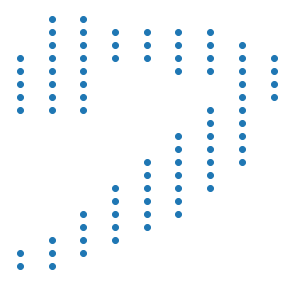

Sample num:  5025 tensor(7)


In [48]:
fig,ax = plt.subplots(figsize=(5,5))
sampleNum = random.randint(0,len(ds))
xy = ds[sampleNum][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()
print('Sample num: ', sampleNum,ds[sampleNum][1])

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [49]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [50]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()

        self.linear_layer1 = nn.Linear(2,10)
        self.linear_layer2 = nn.Linear(10,20)
        self.linear_layer3 = nn.Linear(20,40)
        self.linear_layer4 = nn.Linear(40,100)
        self.linear_layer5 = nn.Linear(100,50)
        self.linear_layer6 = nn.Linear(50,25)
        self.linear_layer7 = nn.Linear(25,10)
   
    def forward(self, x):
    
      x =  F.relu(self.linear_layer1(x))
      x =  F.relu(self.linear_layer2(x))
      x =  F.relu(self.linear_layer3(x))
      x =  F.relu(self.linear_layer4(x))

      x = torch.mean(x,dim=1)

      x = F.relu(self.linear_layer5(x))
      x = F.relu(self.linear_layer6(x))
      x = F.relu(self.linear_layer7(x))
                 
      return x

In [51]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    net = net.to('cpu')

    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:

        x = x.to('cpu')
        y = y.to('cpu')
        prediction = net(x).data.numpy()
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [52]:
net = DeepSet()
net = net.to(device)

In [69]:
# Loading training and validation data
batch_size = 50

ds = CustomDataset(trainingPath)
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
data_loader = DataLoader(ds, batch_sampler=batch_sampler)

test_ds = CustomDataset(validationPath)
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

In [70]:
#  Defining loss function
loss_func = nn.CrossEntropyLoss()

In [71]:
#  Choosing optimizing method
optimizer = optim.SGD(net.parameters(), lr = 0.001)

In [72]:
#  Training data
n_epochs = 4

accuracy_vs_epoch = []

for epoch in tqdm(range(n_epochs)):

    net.train()
    
    for x, y in data_loader:
       
        x = x.to(device)
        y = y.to(device)
        net = net.to(device)

        
        #  Forward step
        output = net(x)
        #  Calculate loss function
        loss = loss_func(output,y)
        #  Set gradient to zero
        optimizer.zero_grad()
        #  Backward step
        loss.backward()
        #  Updating optimizer
        optimizer.step()


    net.eval()
    #  Calculate accuracy and append    

    training_accuracy = compute_accuracy(data_loader_test,net)
    validation_accuracy = compute_accuracy(data_loader,net)

    accuracy_vs_epoch.append([training_accuracy, validation_accuracy])
    print('Training accuracy', training_accuracy,'Validation accuracy',validation_accuracy)

Training accuracy 0.098 Validation accuracy 0.1001
Training accuracy 0.098 Validation accuracy 0.1001
Training accuracy 0.098 Validation accuracy 0.1001
Training accuracy 0.098 Validation accuracy 0.1001



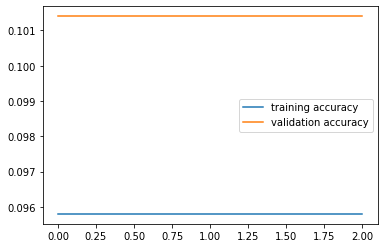

In [42]:
#  Plot Accuracy vs epoch

accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:, 0][1:], label='training accuracy')
plt.plot(accuracy_vs_epoch[:, 1][1:], label='validation accuracy')

plt.legend()

plt.show()

In [61]:
accuracy_vs_epoch

[[0.098, 0.1001], [0.098, 0.1001], [0.098, 0.1001], [0.098, 0.1001]]